In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase.build import nanotube
from ase.neighborlist import NeighborList
from scipy.linalg import eigh
from ase.visualize import view


In [ ]:
def create_nanotube(n=6, m=0, length=2, bond=1.42, pbc=True, direction="x"):

    """Create a carbon nanotube (CNT) using ASE.

    Args:
        n (int): Chiral index n.
        m (int): Chiral index m.
        length (int): Number of unit cells.
        bond (float): Carbon-carbon bond length.
        pbc (bool): Whether to apply periodic boundary conditions.
        direction (str): Direction of periodicity ('x', 'y', or 'z').

    Returns:
        ase.Atoms: ASE Atoms object representing the CNT.
    """
    atoms = nanotube(n=n, m=m, length=length, bond=bond,verbose=False)
    atoms.rotate('z', 'x', rotate_cell=True, center='COP')
    if pbc:
        if direction == "x":
            atoms.set_pbc((1, 0, 0))
        elif direction == "y":
            atoms.set_pbc((0, 1, 0))
        elif direction == "z":
            atoms.set_pbc((0, 0, 1))
        else:
            raise ValueError("Invalid direction. Use 'x', 'y', or 'z'.")
    return atoms

def build_real_space_lead_hamiltonian(atoms, bond=1.42, beta=0.0, t0=-2.7, neighbor_cutoff=1.43, atol=0.1):

    """Build the intra-cell (H0) and inter-cell (T) Hamiltonians for a CNT lead.

    Args:
        atoms (ase.Atoms): CNT structure with two unit cells.
        bond (float): Ideal bond length (in angstrom).
        beta (float): Exponential decay parameter for hopping.
        t0 (float): Nearest-neighbor hopping at ideal bond length (in eV).
        neighbor_cutoff (float): Distance threshold to consider neighbors.
        atol (float): Absolute tolerance in bond length matching.

    Returns:
        Tuple[np.ndarray, np.ndarray]: H0 and T matrices (both shape (N, N)).
    """
    N_total = len(atoms)
    N_unit = N_total // 2  # atoms in one unit cell

    positions = atoms.get_positions()
    cell = atoms.get_cell()

    # Neighbor list
    cutoffs = [neighbor_cutoff] * N_total
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    # Initialize Hamiltonians
    H0 = np.zeros((N_unit, N_unit), dtype=float)
    T = np.zeros((N_unit, N_unit), dtype=float)

    for i in range(N_total):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j <= i:
                continue
            ri = positions[i]
            rj = positions[j] + np.dot(offset, cell)
            dist = np.linalg.norm(ri - rj)
            if np.abs(dist - bond) > atol:
                continue  # skip non-neighbors
            hopping = t0 * np.exp(-beta * (dist / bond - 1))

            # Intra-cell bond
            if i < N_unit and j < N_unit:
                H0[i, j] = hopping
                H0[j, i] = hopping

            # Inter-cell bond (only to the unit cell immediately to the right)
            elif i < N_unit and j >= N_unit and np.all(offset == [1, 0, 0]):
                T[i, j - N_unit] = hopping

    return H0, T


In [144]:
# Parameters
n, m = 6, 0
ncells = 2
bond = 1.42
onsite = 0.0  # eV
first_neighbor_hopping = -2.7  # eV
beta = 0 #3.37
neighbor_cutoff = 1.43  # Å for nearest neighbors
d0 = bond


In [145]:
leads = create_nanotube(n=n, m=m, length=ncells, bond=bond, pbc=True, direction="x")
view(leads, viewer="x3d", show_unit_cell=True, show_bonds=True, bond_radius=0.1)


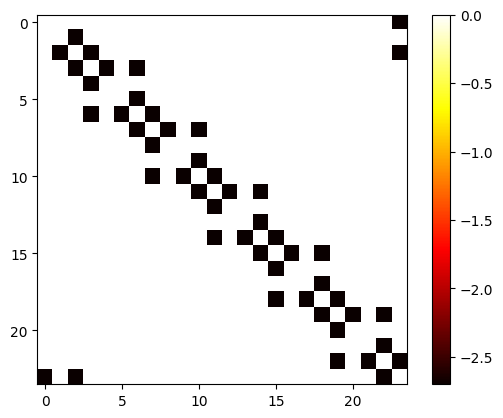

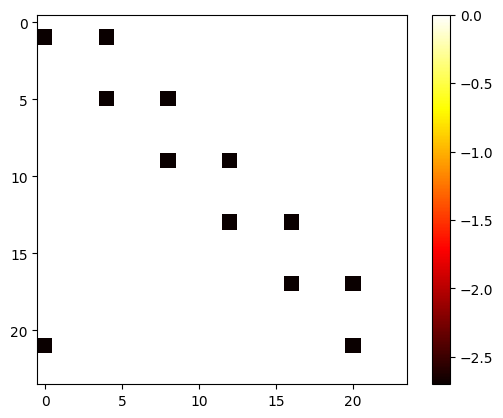

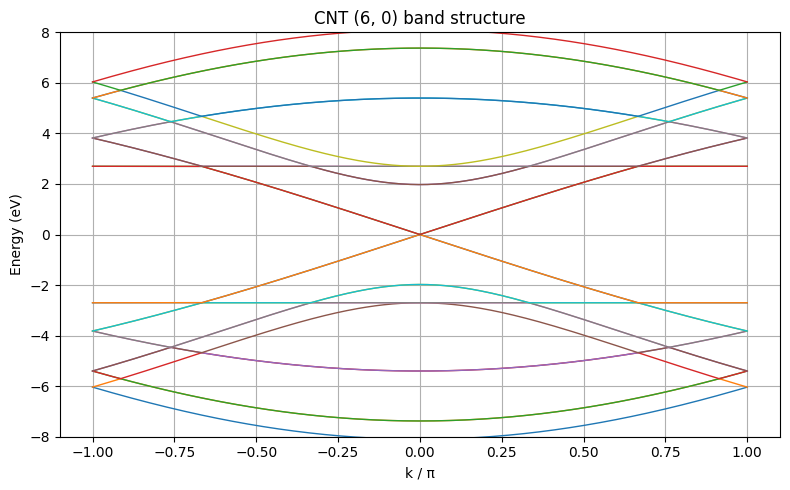

In [ ]:
H, T = build_real_space_lead_hamiltonian(leads, beta=beta, t0=first_neighbor_hopping, neighbor_cutoff=neighbor_cutoff, atol=0.1)
plt.imshow(H, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(T, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
